<a href="https://colab.research.google.com/github/kk2a/portfolio/blob/main/%E8%AA%B2%E9%A1%8C05_15_TS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **オセロ**

## **概要**

オセロができます.



## **操作方法**

特にないです.
基本的なことは説明されます

## **制作者のコメント**

オセロのGUIを考えるにあたってGPT3.5に相談し,出力されたプログラムの大部分を引用している.しかし,アルゴリズムは全部自分で書いた.

発言などをいじりやすくしたためコピーして,いじってみてほしい.

このプログラムは何度かの改良を重ねてアップデートしていった末に完成したものである.その発展途上の段階のものは[ここに](https://colab.research.google.com/drive/1hNafmJp1mZxpmjn1ynHN0_8a0lKOyM0w?usp=sharing)置いておいた.

**Appendices**もぜひ見てほしい.偶然気づいたことに関することについてまとめた.

## **作成時間**

作成時間：**約20時間**


# **プログラム本体**
### セルを表示して,それぞれ順番に実行して下さい.

In [ ]:
# @title **初めてやるときはこちらを実行してください**

import numpy
import matplotlib.pyplot as plt
import random
from IPython.display import clear_output
import copy


#@markdown ### オセロ盤のサイズ

BOARD_SIZE = "6" #@param [6, 8, 10]
BOARD_SIZE = int(BOARD_SIZE)
assert BOARD_SIZE % 2 - 1

# プレイヤーを表す定数
EMPTY = 0
BLACK = 1
WHITE = -1

# 8つの方向
direction = [[1, 1], [1, 0], [1, -1], [0, 1], [0, -1], [-1, 1], [-1, 0], [-1, -1]]

# emoji
emoji= ["😄", "😭", "🙂", "😑"]

# ショートカット

# 入力が整数かどうかの判定
def is_nice_int(st, i, j):
    nice_list = list(map(str, range(i, j + 1)))
    if st in nice_list:
        return True
    return False

# emoji
def random_emoji():
    return emoji[random.randint(0, len(emoji) - 1)]

# 発言

# ターン説明
def your_turn(i, now_turn):
    if i:
        print(f"{'黒' if now_turn + 1 else '白'}のターンです{random_emoji()}")
    else:
        # スキップが発生したとき
        print(f"{'黒' if now_turn + 1 else '白'}は置く手が存在しないようです😂")
        print(f"なので{'白' if now_turn + 1 else '黒'}のターンです{random_emoji()}")

# 入力制限
def input_rule(i, lw_bound, up_bound):
    if i:
        print(f"{lw_bound}以上{up_bound}以下の整数を入力してください{random_emoji()}")
    else:
        # 入力形式に沿ってくれなかったとき
        print(f"{lw_bound}以上{up_bound}以下の整数を入力してください{random_emoji()}")

# undoの説明
def undo_how_to():
    print(f"0を入力するとundoできます{random_emoji()}")


# 勝敗と石の数
def fin_game(board):
    draw_board(board)
    [black_sum, white_sum] = count_stone(board)
    if black_sum > white_sum:
        print("黒の勝利!!!!!おめでとう😺")
    elif black_sum < white_sum:
        print("白の勝利!!!!!おめでとう😺")
    else:
        print("引き分け!!!!!おめでとう💩")

    print(f"詳細:黒の数{black_sum},白の数{white_sum}")

# 初期化
def init_sent():
    print("初期化しますか。", "はい -> 'y'", "いいえ -> 'n'", sep = "\n")


# アルゴリズム

# オセロ盤の初期化
def create_board():
    board = numpy.zeros((BOARD_SIZE, BOARD_SIZE), dtype=int)
    center = BOARD_SIZE // 2
    board[center - 1, center - 1] = WHITE
    board[center, center] = WHITE
    board[center - 1, center] = BLACK
    board[center, center - 1] = BLACK
    return board

# オセロ盤の描画
def draw_board(board):
    clear_output()
    plt.close()
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_xlim(-0.5, BOARD_SIZE - 0.5)
    ax.set_ylim(-0.5, BOARD_SIZE - 0.5)
    fig.patch.set_facecolor('green')

    # 枠組み
    for i in range(BOARD_SIZE + 1):
        ax.add_line(plt.Line2D([i - 0.5, i - 0.5], [-0.5, BOARD_SIZE - 0.5], color='black'))
        ax.add_line(plt.Line2D([-0.5, BOARD_SIZE - 0.5], [i - 0.5, i - 0.5], color='black'))

    # 石
    for i in range(BOARD_SIZE):
        for j in range(BOARD_SIZE):
            if board[i][j] == BLACK:
                ax.add_patch(plt.Circle((j, i), 0.4, fc='black'))
            elif board[i][j] == WHITE:
                ax.add_patch(plt.Circle((j, i), 0.4, fc='white'))
            elif 0 < board[i][j] - 1 < 10:
                plt.text(j - 0.1, i - 0.08, board[i][j] - 1, size = 'x-large', color = 'red')
            elif 10 <= board[i][j] - 1:
                plt.text(j - 0.20, i - 0.08, board[i][j] - 1, size = 'x-large', color = 'red')
    plt.show()

# 数字を改める
def clean_up(board):
    for k in range(BOARD_SIZE):
        for l in range(BOARD_SIZE):
            if not(board[k][l] in [-1, 1]):
                board[k][l] = 0

# 置ける石の場所のメモ
def valid_move(board, now_turn):
    clean_up(board)
    num = 1

    for i in range(BOARD_SIZE):
        for j in range(BOARD_SIZE):
            if not board[i][j] in [-1, 1]:
                can_put_on = False
                for k in direction:
                    now_i = i + k[0]
                    now_j = j + k[1]
                    numnum = 0

                    while not can_put_on:
                        if not(0 <= now_i < BOARD_SIZE and 0 <= now_j < BOARD_SIZE):
                            break
                        elif not(board[now_i][now_j] in [-1, 1]):
                            break

                        if board[now_i][now_j] + now_turn:
                            if numnum: can_put_on = True
                            break
                        else:
                            numnum = numnum + 1
                        now_i = now_i + k[0]
                        now_j = now_j + k[1]

                    if can_put_on:
                        num = num + 1
                        break
                if can_put_on:
                    board[i][j] = num
    return num

# 石をひっくり返す
def reverse_stone(next_stone, board, now_turn):
    i, j = numpy.argwhere(board == next_stone + 1)[0][0], numpy.argwhere(board == next_stone + 1)[0][1]
    board[i][j] = now_turn
    for k in direction:
        nice_direction = False
        now_i = i + k[0]
        now_j = j + k[1]
        numnum = 0

        while True:
            if not(0 <= now_i < BOARD_SIZE and 0 <= now_j < BOARD_SIZE):
                break
            elif not(board[now_i][now_j] in [-1, 1]):
                break

            if board[now_i][now_j] + now_turn:
                if numnum: nice_direction = True
                break
            else: numnum = numnum + 1
            now_i = now_i + k[0]
            now_j = now_j + k[1]

        if nice_direction:
            for l in range(numnum + 1):
                board[i + k[0] * l][j + k[1] * l] = now_turn

# 石のカウント
def count_stone(board):
    return [numpy.sum(board == BLACK), numpy.sum(board == WHITE)]

# 入力
def input_int(i, board, up_bound, now_turn, turn):
    if turn:
        draw_board(board)
        your_turn(i, now_turn)
        input_rule(1, 0, up_bound)
        undo_how_to()
        next_stone = input()
        while not is_nice_int(next_stone, 0, up_bound):
            draw_board(board)
            your_turn(i, now_turn)
            input_rule(0, 0, up_bound)
            undo_how_to()
            next_stone = input()
        return int(next_stone)
    else:
        draw_board(board)
        your_turn(i, now_turn)
        input_rule(1, 1, up_bound)
        next_stone = input()
        while not is_nice_int(next_stone, 1, up_bound):
            draw_board(board)
            your_turn(i, now_turn)
            input_rule(0, 1, up_bound)
            next_stone = input()
        return int(next_stone)

# undo
def undo(board, board_record, turn_record):
    assert len(board_record)
    assert len(turn_record)
    b = board_record.pop(-1)
    for i in range(BOARD_SIZE):
        for j in range(BOARD_SIZE):
            board[i][j] = b[i][j]
    return turn_record.pop(-1)

# メモボード
def memo(board, board_record, turn_record):
    board_record.append(copy.deepcopy(board))
    turn_record.append(now_turn)

# index探(遅いし重いけどまあいいや🙂🙂🙂🙂🙂🙂🙂🙂)
def reverse_or_undo(board, next_stone, now_turn, board_record, turn_record):
    if next_stone:
        memo(board, board_record, turn_record)
        reverse_stone(next_stone, board, now_turn)
        return -now_turn
    else:
        return undo(board, board_record, turn_record)


# 初期設定
board = create_board()

# 先行は黒
now_turn = BLACK

# 履歴
board_record = []
turn_record = []

# 回数の制御
init = 0

In [ ]:
# @title オセロ開始

if init:
    init_sent()
    res = input()
    while not res in ["y", "n"]:
        clear_output()
        init_sent()
        res = input()
    if res == "y":
        # 初期設定
        board = create_board()

        # 先行は黒
        now_turn = BLACK

        # 履歴
        board_record = []
        turn_record = []

        # 回数の制御
        init = 0
init = init + 1

while True:
    tmp = valid_move(board, now_turn) - 1
    if tmp:
        next_stone = input_int(1, board, tmp, now_turn, len(turn_record))
        now_turn = reverse_or_undo(board, next_stone, now_turn, board_record, turn_record)

    elif valid_move(board, -now_turn) - 1:
        tmp = valid_move(board, -now_turn) - 1
        next_stone = input_int(0, board, tmp, now_turn, len(turn_record))
        now_turn = reverse_or_undo(board, next_stone, -now_turn, board_record, turn_record)

    else:
        break

fin_game(board)

# $\textbf{Appendices}$
### [pdf版はこちら](https://github.com/kk2a/.pdf/blob/main/pdf/2023_progamming_jiyukadai.pdf)

### 以下はpng版です.(ズームアウトする見やすい.)

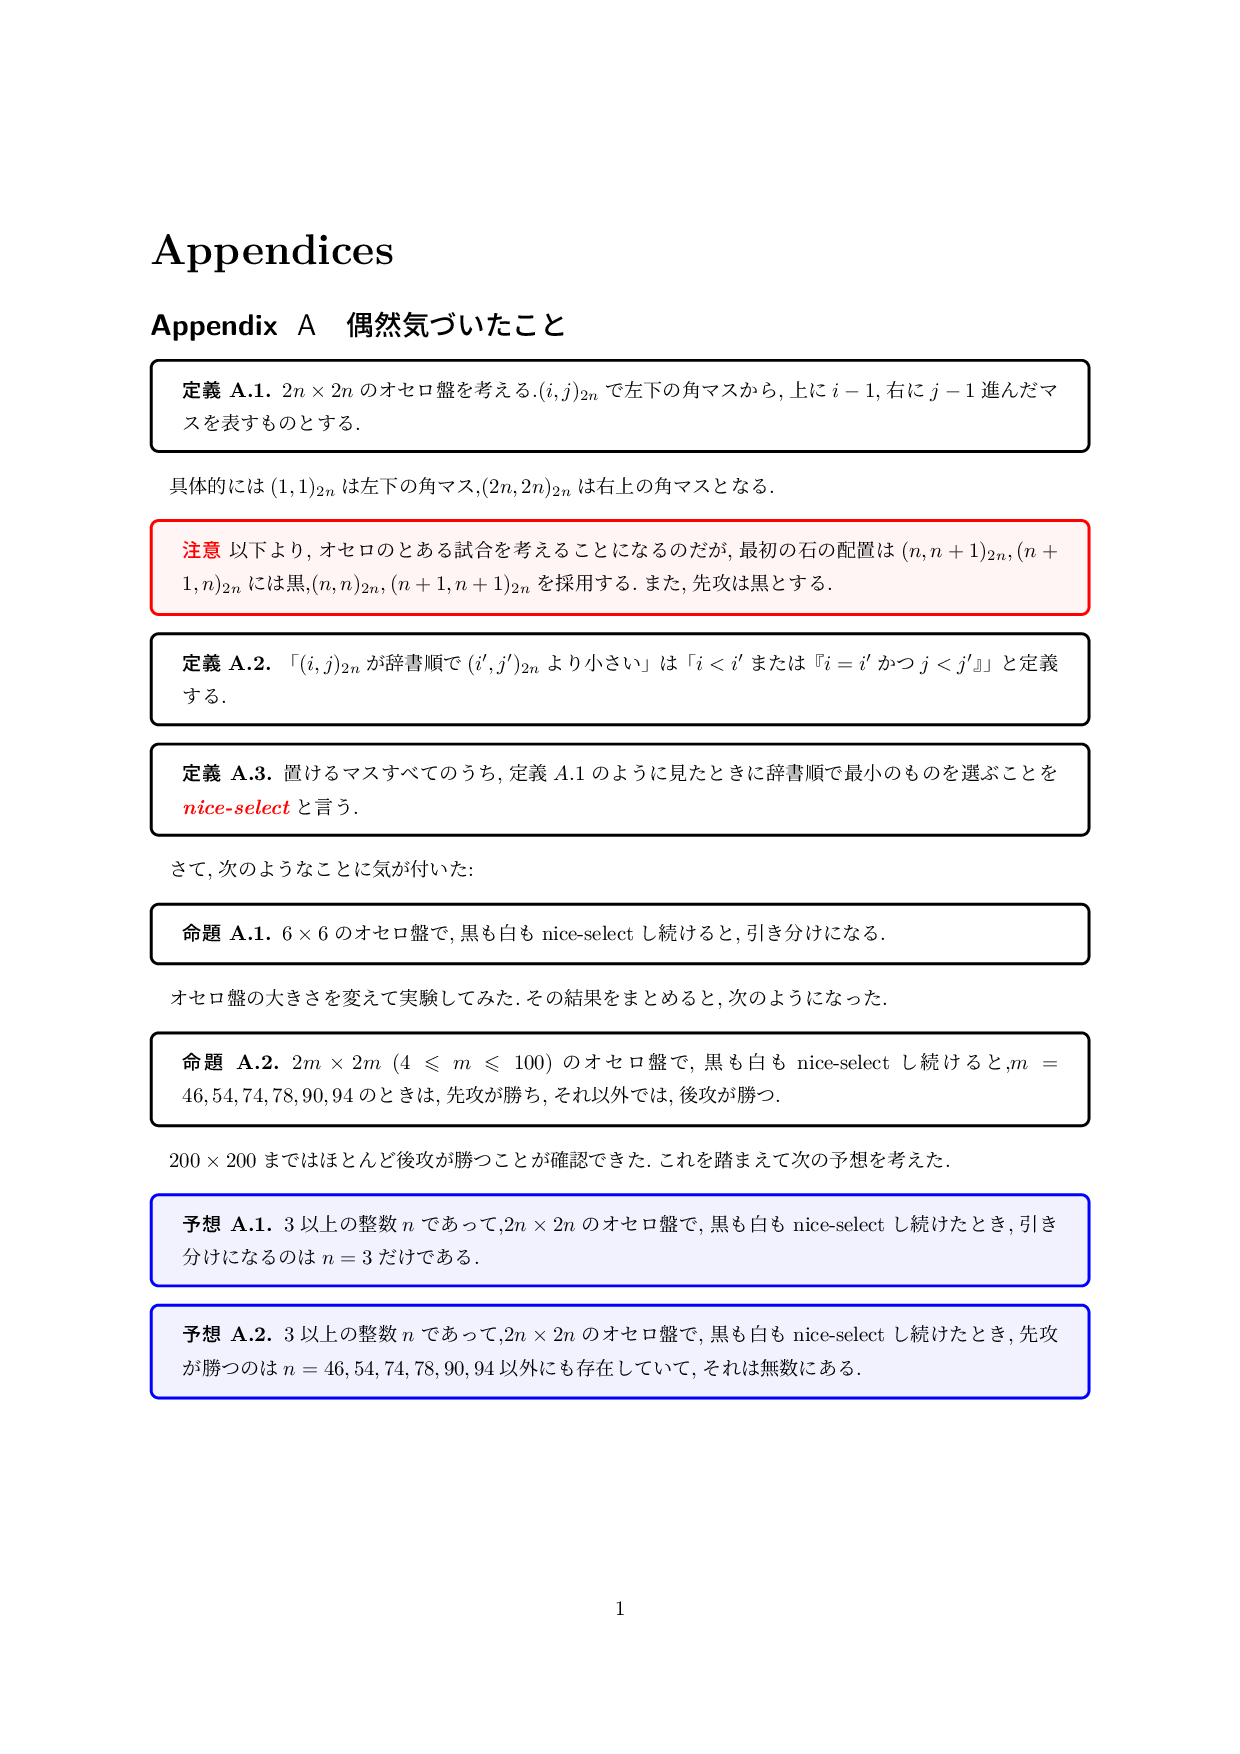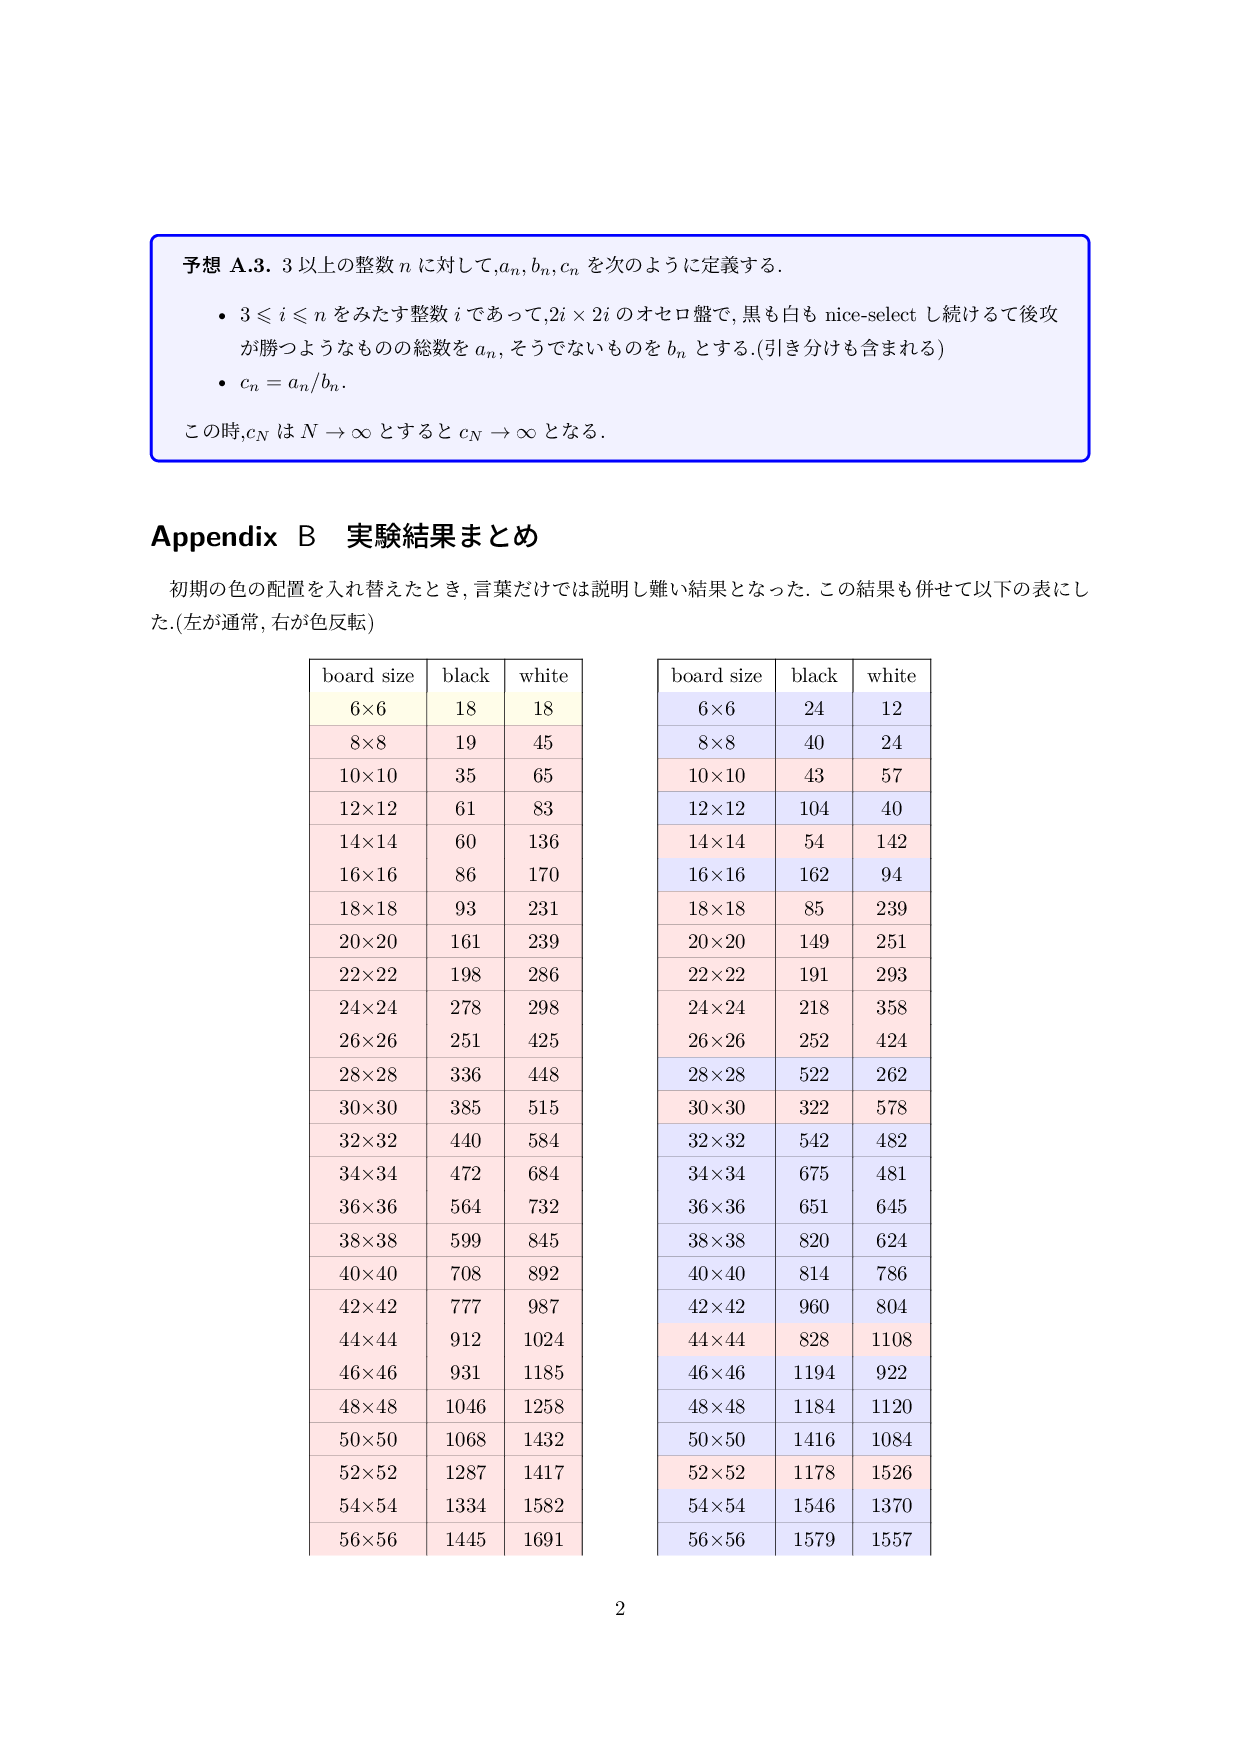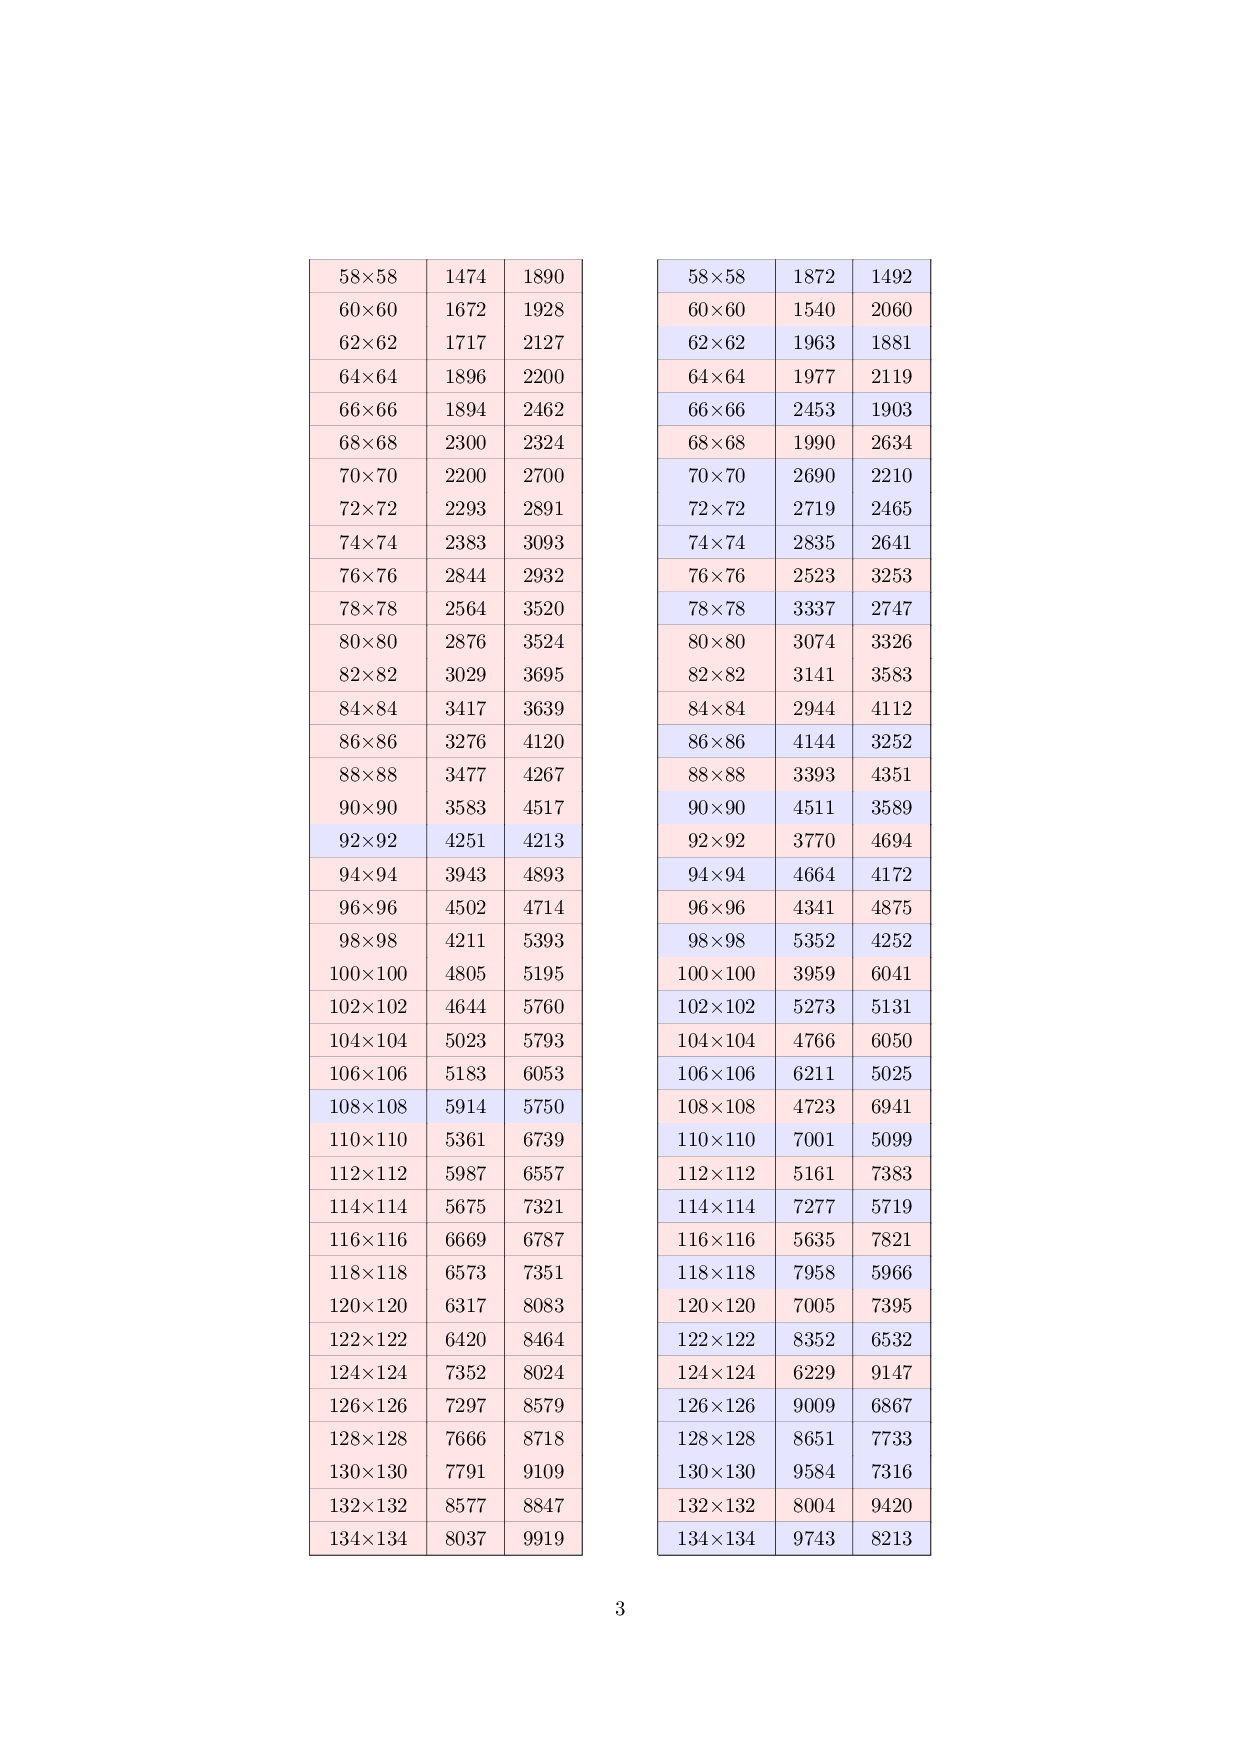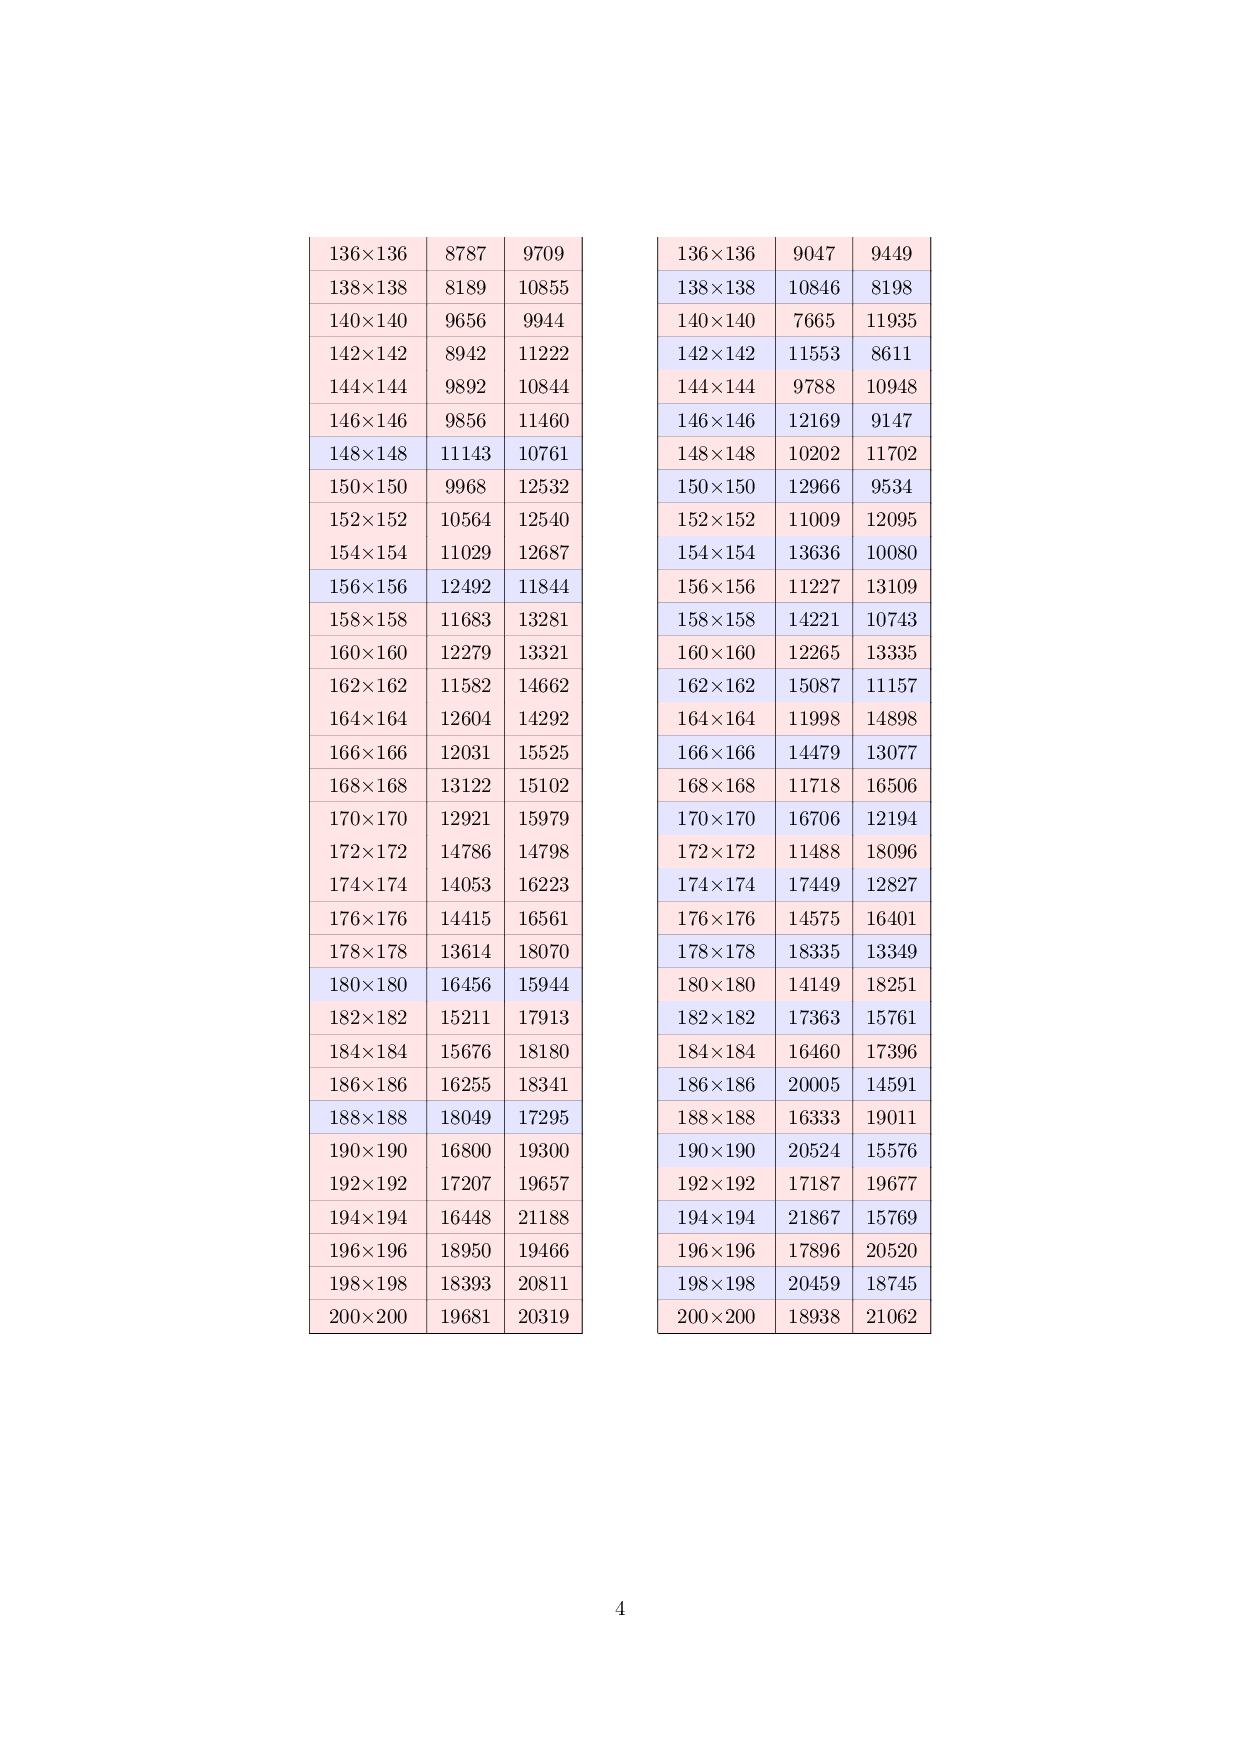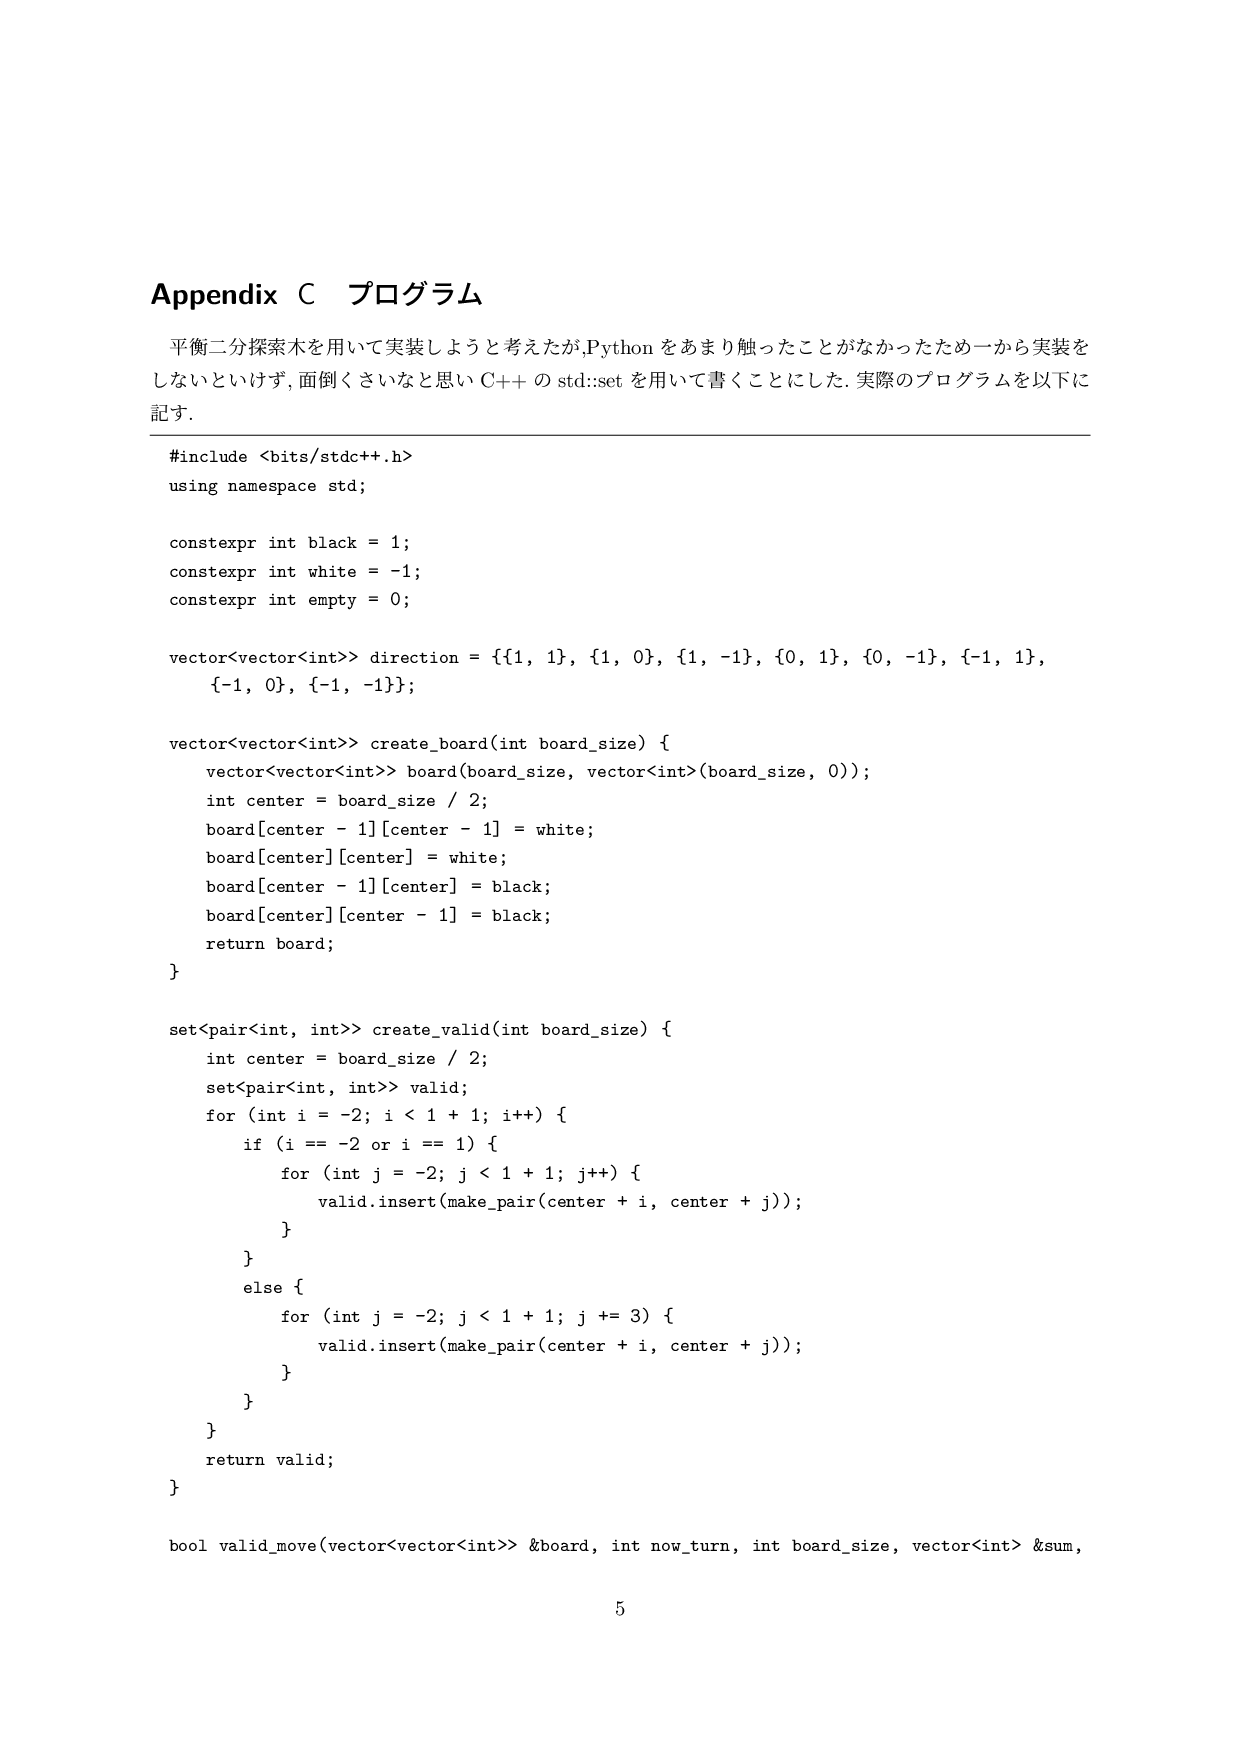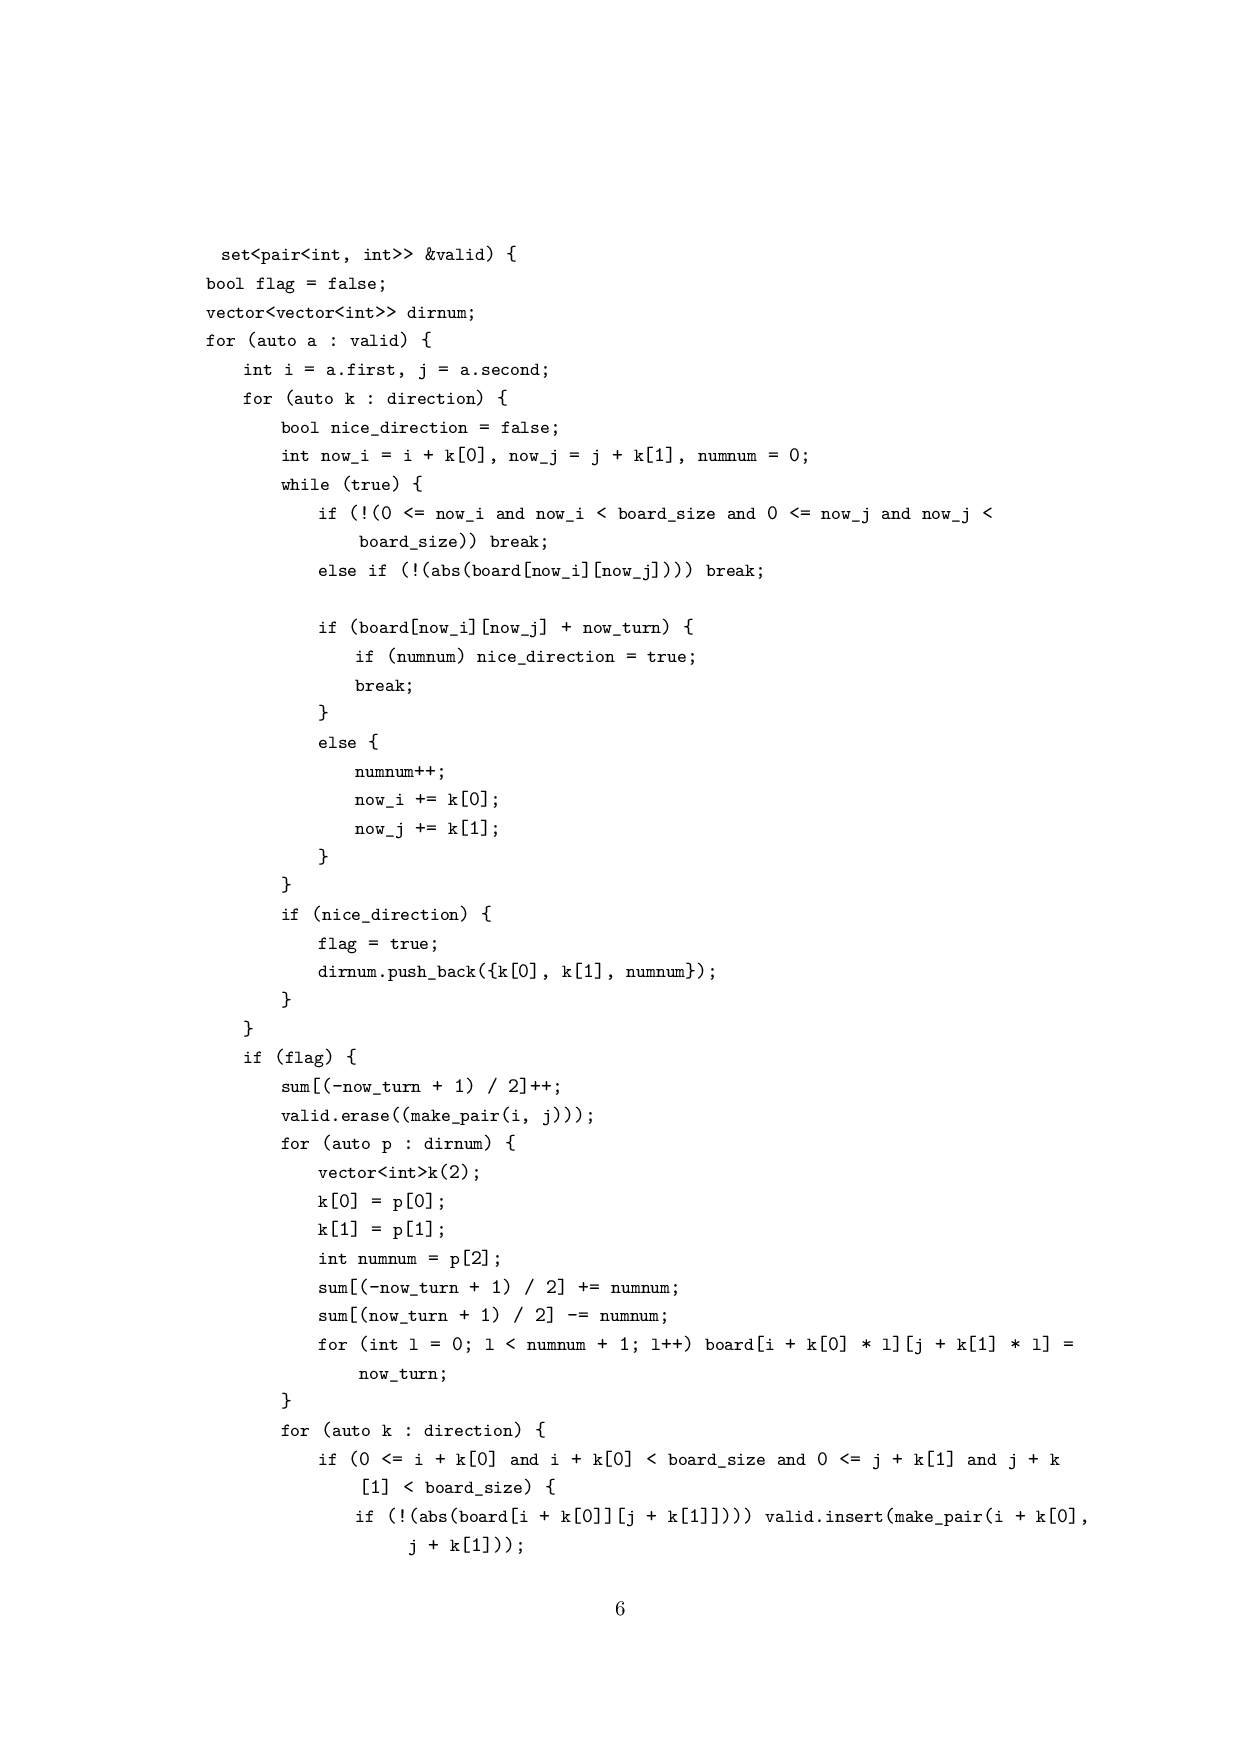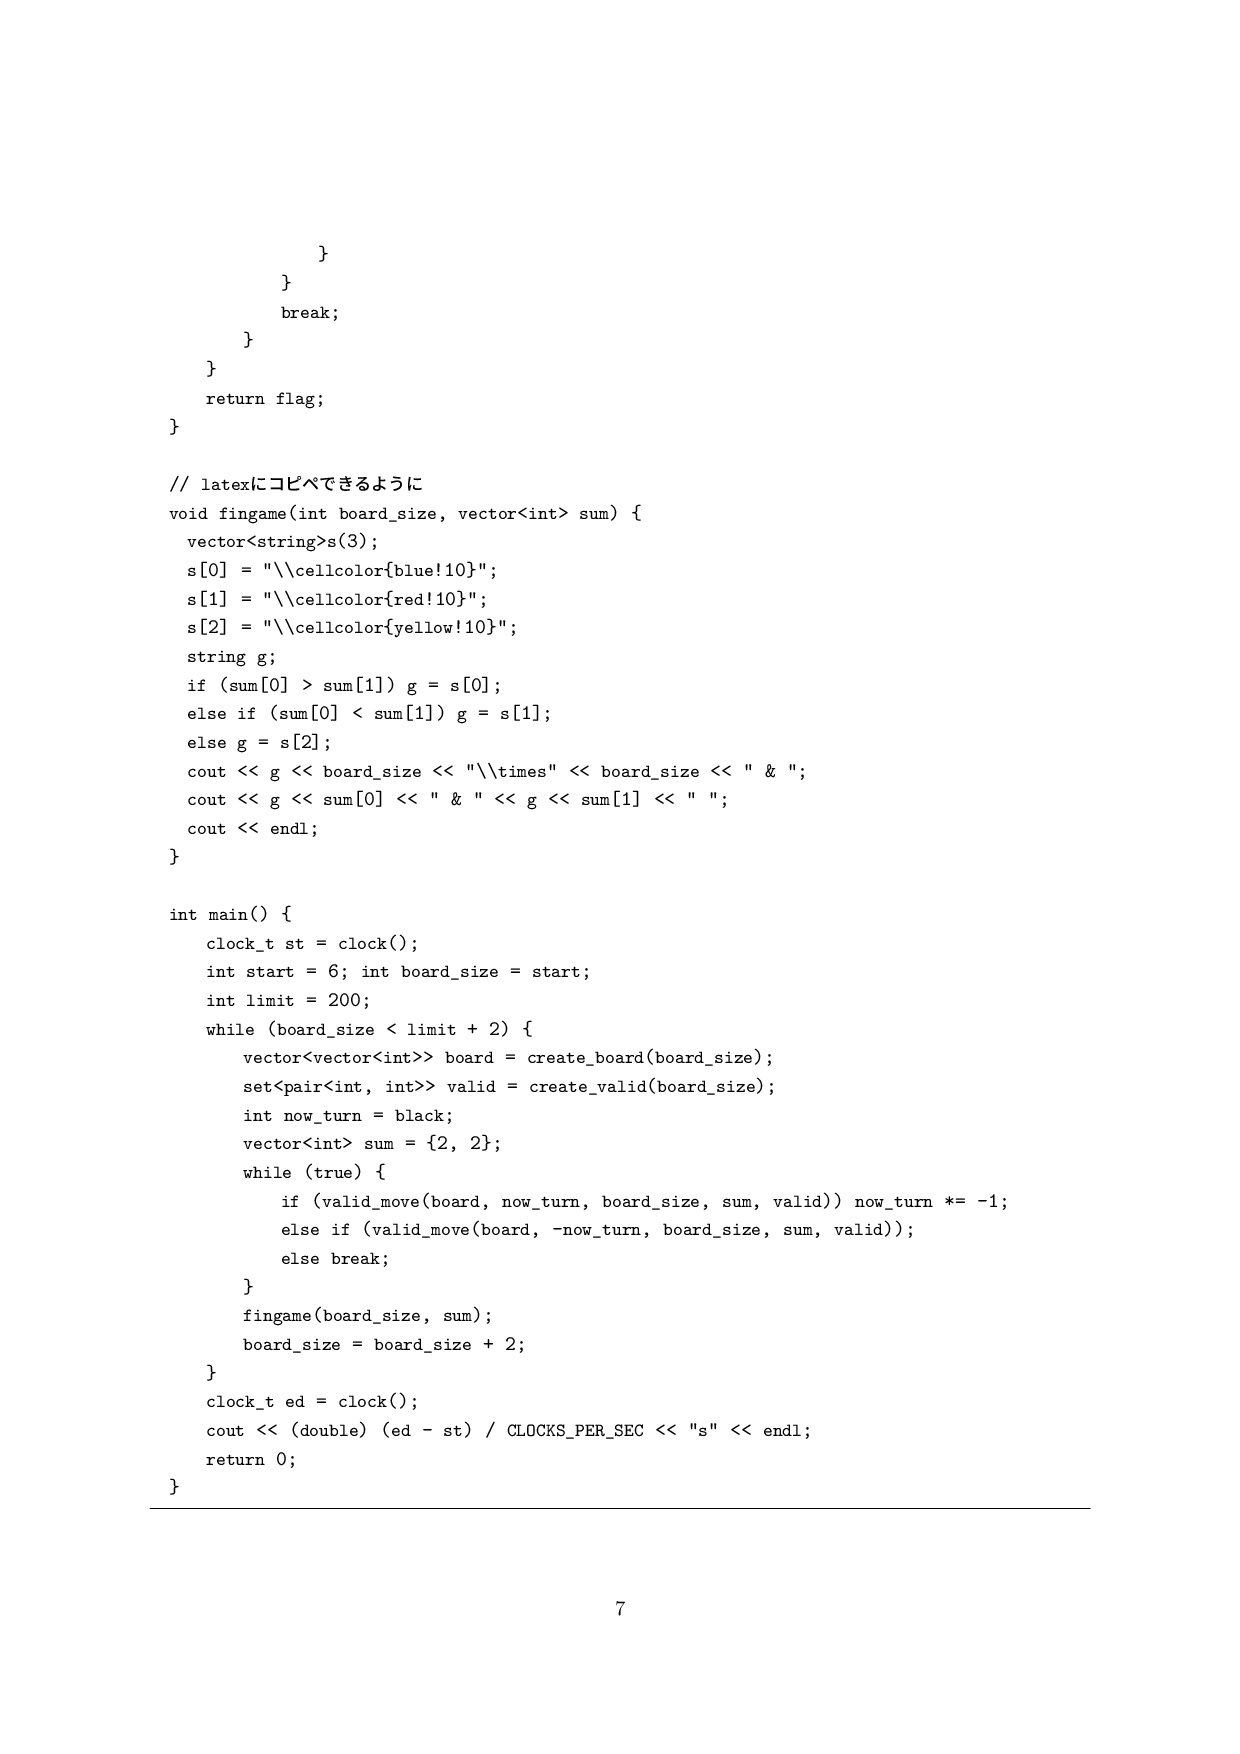